# Problema de Negócio: Empresa Trend Jeans

## A empresa Trend Jeans!
Eduardo e Marcelo são dois brasileiros, amigos e sócios de empreendimento. Depois de vários negócios bem sucedidos, eles estão planejando entrar no mercado de moda dos USA como um modelo de negócio do tipo E-commerce.

A idéia inicial é entrar no mercado com apenas um produto e para um público específico, no caso o produto seria calças Jeans para o público masculino. O objetivo é manter o custo de operação baixo e escalar a medida que forem conseguindo clientes.

Porém, mesmo com o produto de entrada e a audiência definidos, os dois sócios não tem experiência nesse mercado de moda e portanto não sabem definir coisas básicas como preço, o tipo de calça e o material para a fabricação de cada peça.

Assim, os dois sócios contrataram uma consultoria de Ciência de Dados para responder as seguintes perguntas: 
- 1. Quantos tipos de calças e suas cores para o produto inicial? 
- 2. Quais as matérias-prima necessárias para confeccionar as calças?
- 3. Qual o melhor preço de venda para as calças? 
    - 3.1. Qual o melhor preço para bater o concorrente, incluindo preço do material e mão de obra de costura.
    - 3.2. Calcular o lucro de cada peça, tirando o preço do material e mão de obra de costura

A principal concorrente da empresa Trend Jeans é a americana H&M.

## Design de ETL

### Imports

In [1]:
import re
import sqlite3
import requests
import pandas as pd
import numpy as np
import plotly.express as px

from bs4             import BeautifulSoup
from datetime        import datetime
from sqlalchemy      import create_engine
from IPython.display import Image

## Desenho da Arquitetura do ETL

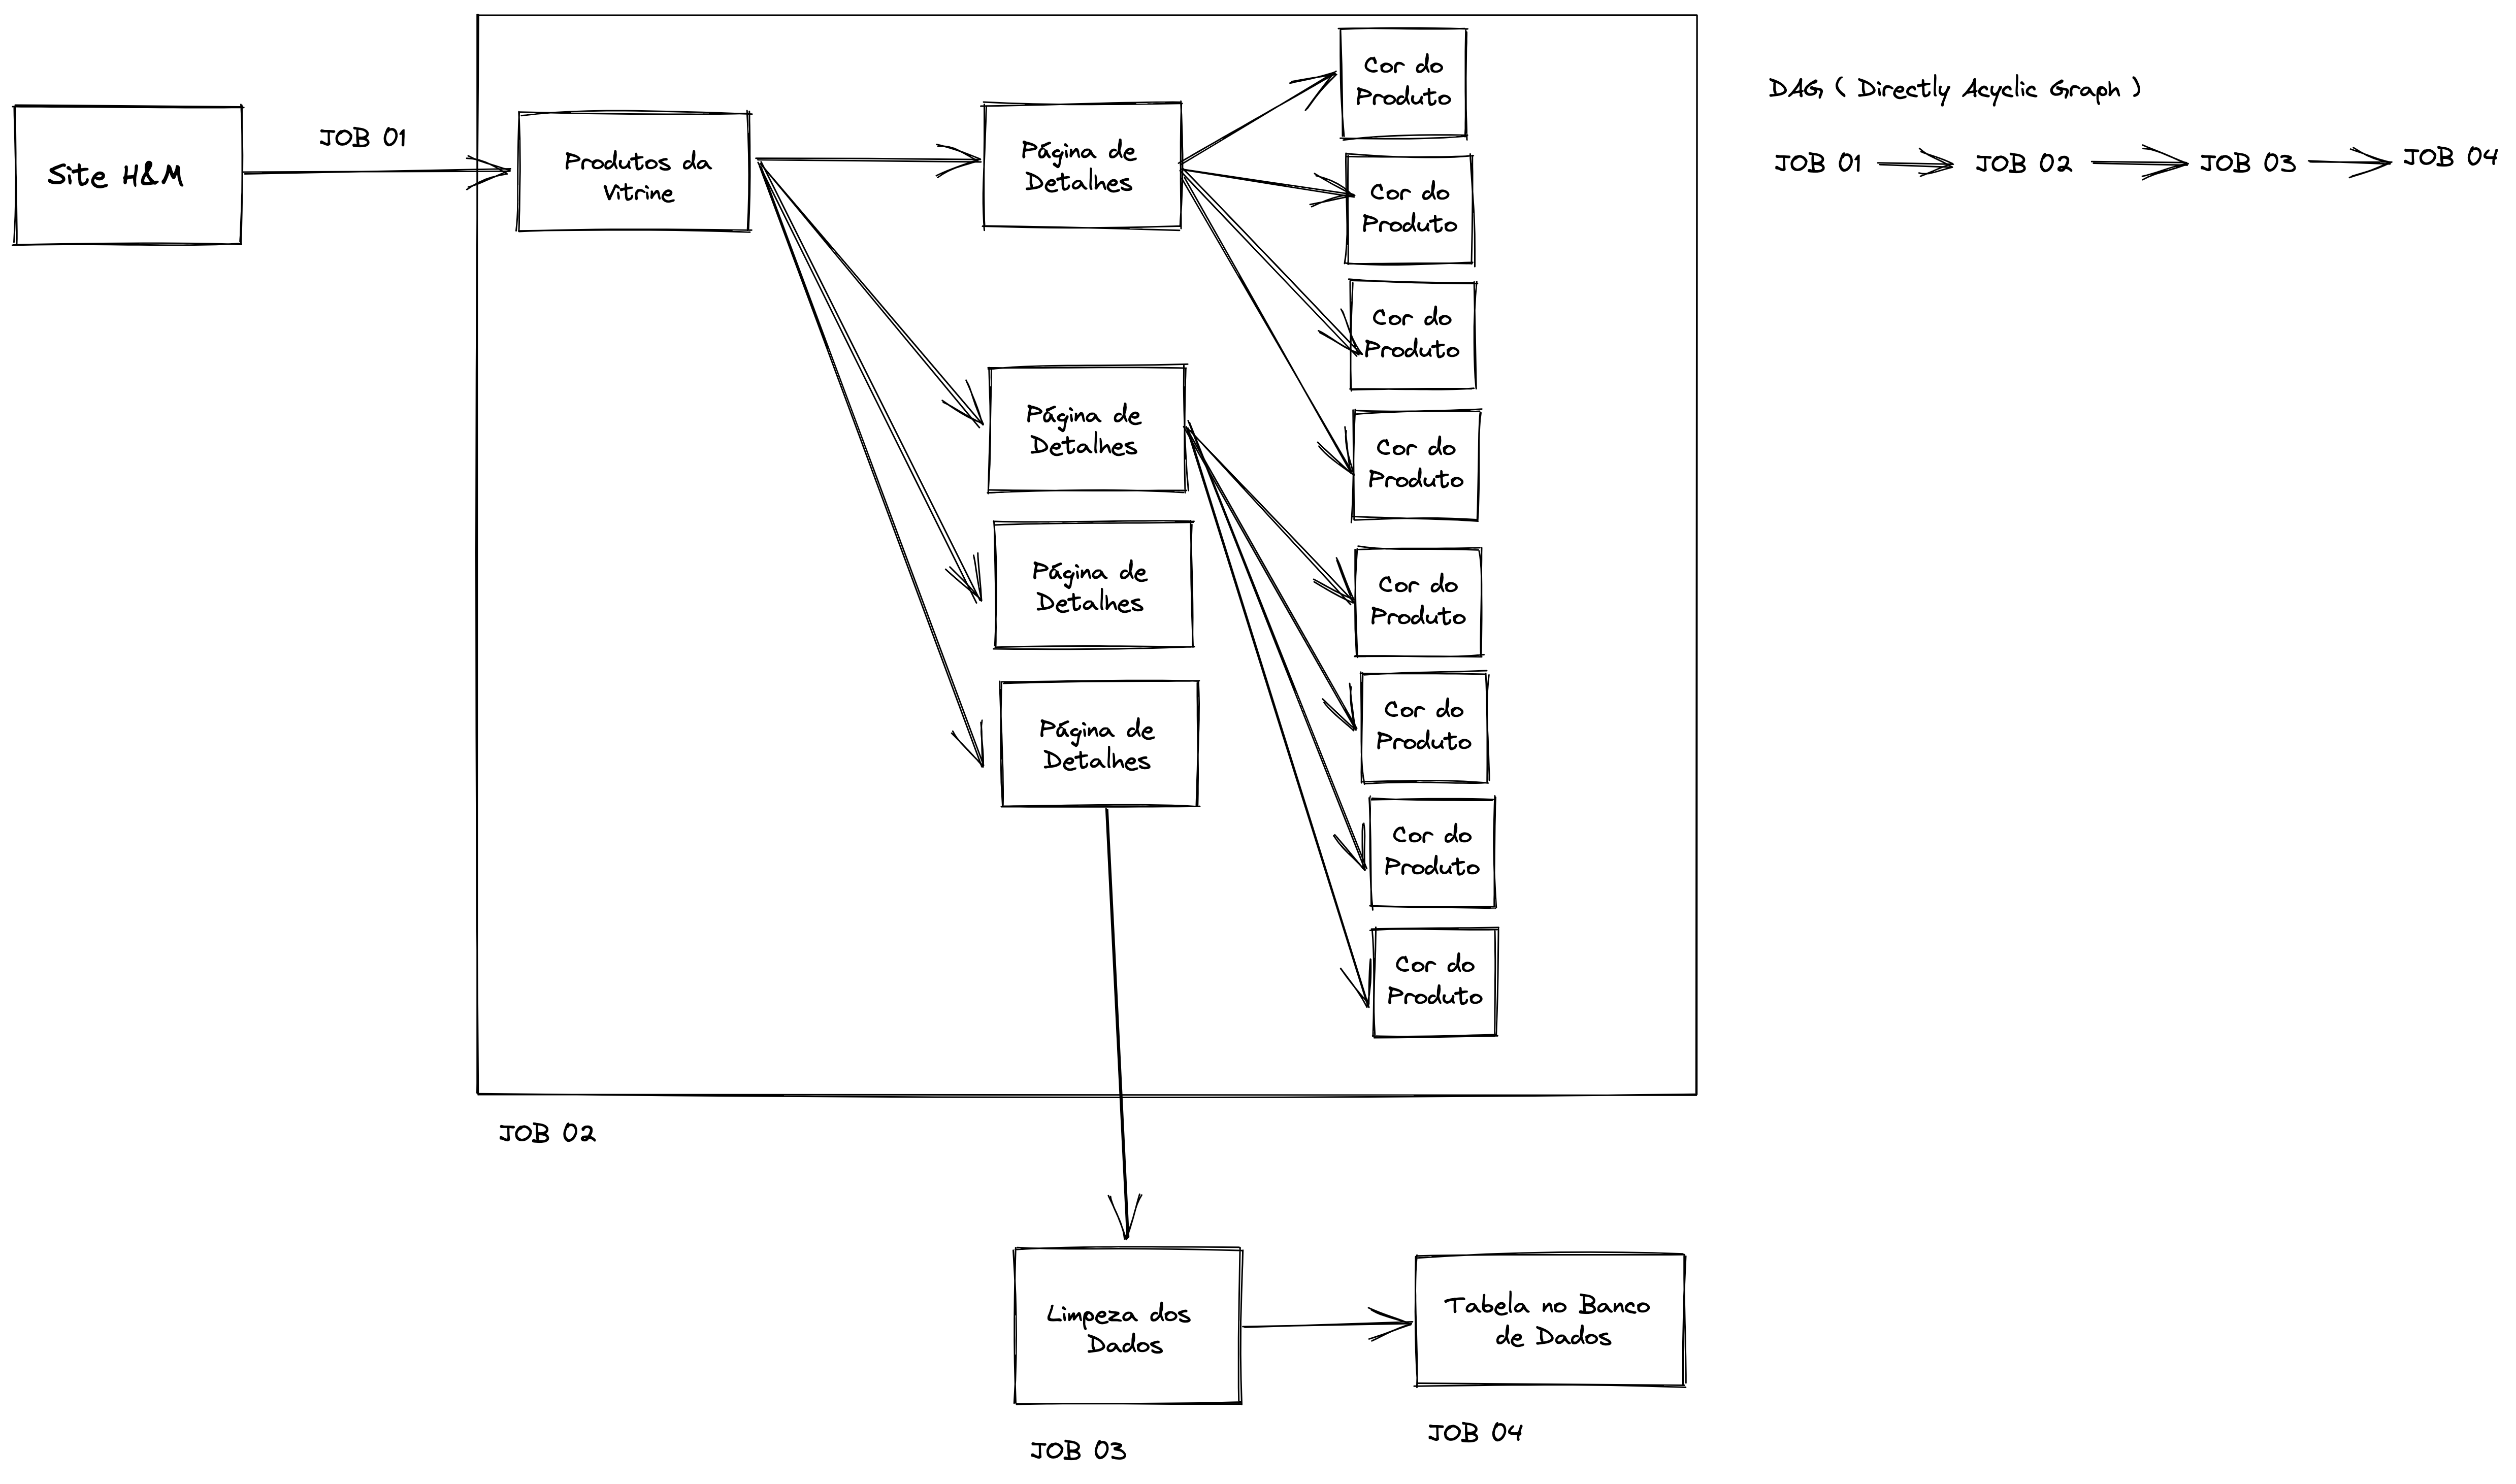

In [2]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/Desenho da arquitetura do ETL.png'
Image(filename = PATH, width=1000, height=1000)

### Data Collection

In [3]:
# parameters
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}

# URL
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

# Request to URL
page = requests.get(url, headers = headers)

# Beautiful soup object
soup = BeautifulSoup(page.text, 'html.parser')

# ================================ Product Data ================================
products = soup.find ('ul', class_='products-listing small')
product_list = products.find_all('article', class_='hm-product-item')

# product id
product_id = [p.get('data-articlecode') for p in product_list]

# product category
product_category = [p.get('data-category') for p in product_list]

# product_name
product_list = products.find_all('a', class_='link')
product_name = [p.get_text() for p in product_list]

# price
product_list = products.find_all('span', class_='price regular')
product_price = [p.get_text() for p in product_list]

data = pd.DataFrame([product_id, product_category, product_name, product_price]).T
data.columns = ['product_id','product_category','product_name','product_price'] # renomenando as colunas


### Data Collection by Product

In [4]:
# Empty dataframe
df_compositions = pd.DataFrame()

# # Unique columns for all products
aux = []

df_pattern = pd.DataFrame(columns = ['Art. No.', 'Composition', 'Fit', 'Size'])

# Collecting products
for i in range (len(data)):
    # API Requests
    url = 'https://www2.hm.com/en_us/productpage.' + data.loc[i, 'product_id'] + '.html'
    print('Product: {}'.format(url))
    
    page = requests.get(url, headers = headers)
    
    # Beautiful Soup object
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # ====================================== Color Name ======================================
    product_list = soup.find_all('a', class_ = 'filter-option miniature active') + soup.find_all('a', class_ = 'filter-option miniature')
    color_name = [p.get('data-color') for p in product_list]

    # product id
    product_id = [p.get('data-articlecode') for p in product_list]

    df_color = pd.DataFrame([product_id, color_name]).T
    df_color.columns = ['product_id', 'color_name']
    
    # Collecting product information for each color
    for j in range (len(df_color)):
        # API Requests
        url = 'https://www2.hm.com/en_us/productpage.' + df_color.loc[j, 'product_id'] + '.html'
        print('Color: {}'.format(url))

        page = requests.get(url, headers = headers)
        
        # Beautiful Soup object
        soup = BeautifulSoup(page.text, 'html.parser')
        
        # ====================================== Product Name ======================================
        product_name = soup.find_all( 'section', class_='product-name-price')
        product_name = product_name[0].get_text()
        
        # ====================================== Product Price ======================================
        product_price = soup.find_all( 'div', class_='primary-row product-item-price')
        product_price = re.findall(r'\d+\.?\d+', product_price[0].get_text())[0]
    
        # ====================================== Composition ======================================
        product_composition_list = soup.find('div', class_='content pdp-text pdp-content').find_all('div')
        product_composition = [list(filter(None, p.get_text().split('\n'))) for p in product_composition_list]

        # Rename dataframe
        df_composition = pd.DataFrame(product_composition).T
        df_composition.columns = df_composition.iloc[0]

        # Delete first row
        df_composition = df_composition.iloc[1:].fillna(method='ffill')

        # Remove pocket lining, shell, lining and pocket
        df_composition['Composition'] = df_composition['Composition'].replace('Pocket lining: ', '', regex=True)
        df_composition['Composition'] = df_composition['Composition'].replace('Pocket: ', '', regex=True)
        df_composition['Composition'] = df_composition['Composition'].replace('Shell: ', '', regex=True)
        df_composition['Composition'] = df_composition['Composition'].replace('Lining: ', '', regex=True)

        # Garantee the same number of columns
        df_composition = pd.concat([df_pattern, df_composition], axis = 0)

        # Rename columns
        df_composition.columns = ['product_id', 'composition', 'fit', 'size']
        
        # New columns product_name and product_price
        df_composition['product_name'] = product_name
        df_composition['product_price'] = product_price

        # Keep new columns if it shows up
        aux = aux + df_composition.columns.tolist()

        # Merge data color + composition
        df_composition = pd.merge(df_composition, df_color, how='left', on = 'product_id')

        # All products
        df_compositions = pd.concat([df_compositions, df_composition], axis = 0)

# Join Showroom data + details
df_compositions['style_id'] = df_compositions['product_id'].apply(lambda x: x[:-3])
df_compositions['color_id'] = df_compositions['product_id'].apply(lambda x: x[-3:])

# scrapy datetime
df_compositions['scrapy_datetime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

Product: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm.com/en_us/productpage.0690449024.html
Color: https://www2.hm.com/en_us/productpage.0690449028.html
Color: https://www2.hm.com/en_us/productpage.0690449035.html
Color: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm.com/en_us/productpage.0690449040.html
Color: https://www2.hm

Color: https://www2.hm.com/en_us/productpage.1024256003.html
Color: https://www2.hm.com/en_us/productpage.1024256004.html
Color: https://www2.hm.com/en_us/productpage.1024256005.html
Color: https://www2.hm.com/en_us/productpage.1024256007.html
Color: https://www2.hm.com/en_us/productpage.1024256008.html
Product: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm

Color: https://www2.hm.com/en_us/productpage.1099503003.html
Product: https://www2.hm.com/en_us/productpage.0690449059.html
Color: https://www2.hm.com/en_us/productpage.0690449059.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm.com/en_us/productpage.0690449024.html
Color: https://www2.hm.com/en_us/productpage.0690449028.html
Color: https://www2.hm.com/en_us/productpage.0690449035.html
Color: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm

Color: https://www2.hm.com/en_us/productpage.1013317010.html
Color: https://www2.hm.com/en_us/productpage.1013317012.html


In [5]:
df_compositions.head()

product_id                composition         fit  \
0  0690449043     Cotton 98%, Spandex 2%  Skinny fit   
1  0690449043  Polyester 65%, Cotton 35%  Skinny fit   
0  0690449001     Cotton 99%, Spandex 1%  Skinny fit   
0  0690449002     Cotton 98%, Spandex 2%  Skinny fit   
0  0690449006     Cotton 98%, Spandex 2%  Skinny fit   

                                             size  \
0  The model is 183cm/6'0" and wears a size 31/32   
1  The model is 183cm/6'0" and wears a size 31/32   
0                                             NaN   
0                                             NaN   
0                                             NaN   

                                        product_name product_price  \
0  \n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n          ...         39.99   
1  \n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n          ...         39.99   
0  \n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n          ...         13.99   
0  \n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n          ...         14.99   
0  \n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n          ...          7.99   

                 color_name style_id color_id      scrapy_datetime  
0  Light denim blue/trashed  0690449      043  2022-11-29 11:06:18  
1  Light denim blue/trashed  0690449      043  2022-11-29 11:06:18  
0  Light denim blue/trashed  0690449      001  2022-11-29 11:06:18  
0                Denim blue  0690449      002  2022-11-29 11:06:18  
0              Black/washed  0690449      006  2022-11-29 11:06:18

### Data Cleaning

In [6]:
# product_id
df_data = df_compositions.dropna(subset = ['product_id'])

# product_name
df_data['product_name'] = df_data['product_name'].str.replace('\n', '')
df_data['product_name'] = df_data['product_name'].str.replace('\r', '-')
df_data['product_name'] =  df_data['product_name'].apply(lambda x: re.sub(r'-(.+)','', str(x)))
df_data['product_name'] = df_data['product_name'].str.replace(' ', '_').str.lower()

# product_price
df_data['product_price'] = df_data['product_price'].astype(float)

# color_name
df_data['color_name'] = df_data['color_name'].str.replace(' ', '_').str.lower()

# Fit
df_data['fit'] = df_data['fit'].apply(lambda x: x.replace(' ', '_').lower() if pd.notnull(x) else (x))

# size model
df_data['size_model'] = df_data['size'].apply(lambda x: re.search( '\d{3}cm', x).group(0) if pd.notnull(x) else x)
df_data['size_model'] = df_data['size_model'].apply(lambda x: re.search( '\d+', x).group(0) if pd.notnull(x) else x)

# size number
df_data['size_number'] = df_data['size'].str.extract('(\d+/\\d+)')

# Break composition by comma
df1 = df_data['composition'].str.split(',', expand = True).reset_index(drop=True)

# # ================================= Composition =================================

# Cotton | Spandex | Polyester
df_ref = pd.DataFrame(index = np.arange(len(df_data)), columns = ['cotton', 'spandex', 'polyester'])

# ======================= Search for cotton =======================
df_cotton_0 = df1.loc[df1[0].str.contains('Cotton', na=True), 0]
df_cotton_0.name = 'cotton'

df_cotton_1 = df1.loc[df1[1].str.contains('Cotton', na=True), 1]
df_cotton_1.name = 'cotton'

# Combine
df_cotton = df_cotton_0.combine_first(df_cotton_1)

df_ref = pd.concat( [df_ref, df_cotton], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep = 'last')]

# ======================= Search for polyester =======================
df_polyester_0 = df1.loc[df1[0].str.contains('Polyester', na=True), 0]
df_polyester_0.name = 'polyester'

df_polyester_1 = df1.loc[df1[1].str.contains('Polyester', na=True), 1]
df_polyester_1.name = 'polyester'

# Combine
df_polyester = df_polyester_0.combine_first(df_polyester_1)

df_ref = pd.concat([df_ref, df_polyester], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep = 'last')] 

# ======================= Search for spandex =======================
df_spandex_1 = df1.loc[df1[1].str.contains('Spandex', na=True), 1]
df_spandex_1.name = 'spandex'

df_spandex_2 = df1.loc[df1[2].str.contains('Spandex', na=True), 2]
df_spandex_2.name = 'spandex'

# Combine
df_spandex = df_spandex_1.combine_first(df_spandex_2)

df_ref = pd.concat([df_ref, df_spandex], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep = 'last')]

# Join of combine with product_id
df_aux = pd.concat([df_data['product_id'].reset_index(drop=True), df_ref], axis=1)

# Format composition data
df_aux['cotton'] = df_aux['cotton'].apply(lambda x: int( re.search( '\d+', x).group(0) ) / 100 if pd.notnull(x) else x)
df_aux['spandex'] = df_aux['spandex'].apply(lambda x: int( re.search( '\d+', x).group(0) ) / 100 if pd.notnull(x) else x)
df_aux['polyester'] = df_aux['polyester'].apply(lambda x: int( re.search( '\d+', x).group(0) ) / 100 if pd.notnull(x) else x)

# Final join
df_aux = df_aux.groupby('product_id').max().reset_index().fillna(0)
df_data = pd.merge(df_data, df_aux, on='product_id', how='left')

# Drop columns: excluindo as colunas Size e Composition
df_data = df_data.drop(columns = ['size','composition'], axis=1)

# drop duplicates
df_data = df_data.drop_duplicates().reset_index(drop=True)
df_data.shape

(86, 13)

In [7]:
df_data

product_id          fit                    product_name  product_price  \
0   0690449043   skinny_fit                    skinny_jeans          39.99   
1   0690449001   skinny_fit                    skinny_jeans          13.99   
2   0690449002   skinny_fit                    skinny_jeans          14.99   
3   0690449006   skinny_fit                    skinny_jeans           7.99   
4   0690449007   skinny_fit                    skinny_jeans          14.99   
..         ...          ...                             ...            ...   
81  1013317008  regular_fit  hybrid_regular_tapered_joggers          15.99   
82  1013317010  regular_fit  hybrid_regular_tapered_joggers          22.99   
83  1013317012  regular_fit  hybrid_regular_tapered_joggers          39.99   
84  1100162003  regular_fit      essentials_no_2:_the_jeans          39.99   
85  1100162002  regular_fit      essentials_no_2:_the_jeans          39.99   

                  color_name style_id color_id      scrapy_datetime  \
0   light_denim_blue/trashed  0690449      043  2022-11-29 11:06:18   
1   light_denim_blue/trashed  0690449      001  2022-11-29 11:06:18   
2                 denim_blue  0690449      002  2022-11-29 11:06:18   
3               black/washed  0690449      006  2022-11-29 11:06:18   
4           light_denim_blue  0690449      007  2022-11-29 11:06:18   
..                       ...      ...      ...                  ...   
81                 dark_blue  1013317      008  2022-11-29 11:06:18   
82                     black  1013317      010  2022-11-29 11:06:18   
83          light_denim_blue  1013317      012  2022-11-29 11:06:18   
84                denim_gray  1100162      003  2022-11-29 11:06:18   
85                denim_blue  1100162      002  2022-11-29 11:06:18   

   size_model size_number  cotton  polyester  spandex  
0         183       31/32    0.98       0.65     0.02  
1         NaN         NaN    0.99       0.00     0.01  
2         NaN         NaN    0.98       0.00     0.02  
3         NaN         NaN    1.00       0.00     0.02  
4         NaN         NaN    1.00       0.00     0.02  
..        ...         ...     ...        ...      ...  
81        187         NaN    0.77       0.21     0.02  
82        187         NaN    0.80       0.19     0.01  
83        NaN         NaN    0.78       0.21     0.01  
84        187       31/32    0.99       0.65     0.01  
85        189       31/32    0.99       0.65     0.01  

[86 rows x 13 columns]

## Data Insert

In [8]:
data_insert = df_data[[
    'product_id',
    'style_id',
    'color_id',
    'product_name',
    'color_name',
    'fit',
    'product_price',
    'size_number',
    'size_model',
    'cotton',
    'polyester',
    'spandex',
    'scrapy_datetime'
]]

In [9]:
query_showroom_schema = """
    CREATE TABLE vitrine(
    product_id       TEXT,
    style_id         TEXT,
    color_id         TEXT,
    product_name     TEXT,
    color_name       TEXT,
    fit              TEXT,
    product_price    REAL,
    size_number      TEXT,
    size_model       TEXT,
    cotton           REAL,
    polyester        REAL,
    spandex          REAL,
    scrapy_datetime  TEXT
    )
"""

In [11]:
# Creat table
conn = sqlite3.connect('hm-database.sqlite')
cursor = conn.execute(query_showroom_schema)
conn.commit()

In [12]:
# Create database connection
conn = create_engine( 'sqlite:///hm-database.sqlite', echo=False )

# Data insert
data_insert.to_sql('vitrine', con=conn, if_exists='append', index=False)

In [13]:
query = """
    SELECT * FROM vitrine
"""

df = pd.read_sql_query( query, conn )
df.head()

product_id style_id color_id  product_name                color_name  \
0  0690449043  0690449      043  skinny_jeans  light_denim_blue/trashed   
1  0690449001  0690449      001  skinny_jeans  light_denim_blue/trashed   
2  0690449002  0690449      002  skinny_jeans                denim_blue   
3  0690449006  0690449      006  skinny_jeans              black/washed   
4  0690449007  0690449      007  skinny_jeans          light_denim_blue   

          fit  product_price size_number size_model  cotton  polyester  \
0  skinny_fit          17.99       31/32        183    0.98       0.65   
1  skinny_fit          13.99        None       None    0.99       0.00   
2  skinny_fit          14.99        None       None    0.98       0.00   
3  skinny_fit           7.99        None       None    1.00       0.00   
4  skinny_fit          14.99        None       None    1.00       0.00   

   spandex      scrapy_datetime  
0     0.02  2022-11-28 21:08:16  
1     0.01  2022-11-28 21:08:16  
2     0.02  2022-11-28 21:08:16  
3     0.02  2022-11-28 21:08:16  
4     0.02  2022-11-28 21:08:16

In [14]:
df_raw = pd.read_sql(query, con=conn)

## Análise descritiva dos dados

### 1.0. Passo 01 - Descrição dos dados

In [15]:
df01 = df_raw.copy()

### 1.1. Dimensão dos dados

In [16]:
print( 'Number of Rows: {}'.format( df01.shape[0] ))
print( 'Number of Cols: {}'.format( df01.shape[1] ))

Number of Rows: 180
Number of Cols: 13


### 1.2. Tipos dos dados

In [17]:
df01.dtypes

product_id          object
style_id            object
color_id            object
product_name        object
color_name          object
fit                 object
product_price      float64
size_number         object
size_model          object
cotton             float64
polyester          float64
spandex            float64
scrapy_datetime     object
dtype: object

In [18]:
# Convert object to datetime
df01['scrapy_datetime'] = pd.to_datetime(df01['scrapy_datetime'])

In [19]:
df01.dtypes

product_id                 object
style_id                   object
color_id                   object
product_name               object
color_name                 object
fit                        object
product_price             float64
size_number                object
size_model                 object
cotton                    float64
polyester                 float64
spandex                   float64
scrapy_datetime    datetime64[ns]
dtype: object

### 1.3. Identificação de dados faltantes

In [20]:
df01.isna().sum()

product_id          0
style_id            0
color_id            0
product_name        0
color_name          0
fit                 0
product_price       0
size_number        89
size_model         69
cotton              0
polyester           0
spandex             0
scrapy_datetime     0
dtype: int64

In [21]:
df01.isna().sum() / df1.shape[0]

product_id         0.000000
style_id           0.000000
color_id           0.000000
product_name       0.000000
color_name         0.000000
fit                0.000000
product_price      0.000000
size_number        0.138199
size_model         0.107143
cotton             0.000000
polyester          0.000000
spandex            0.000000
scrapy_datetime    0.000000
dtype: float64

### 1.4. Substituição de dados faltantes

In [22]:
# Estrategia: vamos dropar as colunas size_number e size_model porque não são necessárias para essa primeira análise.
df01 = df01.drop(columns=['size_number', 'size_model']).dropna()
df01.shape

(180, 11)

### 1.5. Descrição dos dados

In [23]:
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.5.1. Atributos numéricos

In [24]:
# tendencia central - media, mediana
t1 = pd.DataFrame(num_attributes.apply(np.mean)).T
t2 = pd.DataFrame(num_attributes.apply(np.median)).T

# disperson - desvio padrao (std), min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concat
m1 = pd.concat([d2, d3, d4, t1, t2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m1

attributes   min    max  range      media  mediana        std      skew  \
0  product_price  7.99  49.99  42.00  30.028889    29.99  11.082200  0.041671   
1         cotton  0.77   1.00   0.23   0.963889     0.99   0.065949 -2.167934   
2      polyester  0.00   1.00   1.00   0.410000     0.65   0.339470 -0.114589   
3        spandex  0.00   0.02   0.02   0.012778     0.01   0.006417 -0.331177   

   kurtosis  
0 -1.011129  
1  3.244819  
2 -1.600251  
3 -0.692871

#### 1.5.2. Atributos categóricos

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

product_id      95
style_id        12
color_id        32
product_name    10
color_name      25
fit              4
dtype: int64

## 2.0. Respondendo as questões de negócio

### 2.1. Quantos tipos de calças e suas cores para o produto inicial?

In [26]:
# Média de preço por tipos de calças
df_mean_price_by_style = df01[['product_name','product_price']].groupby('product_name').mean().sort_values('product_price', ascending=False).reset_index()
df_mean_price_by_style

product_name  product_price
0             freefit®_slim_jeans      49.990000
1                     baggy_jeans      39.990000
2      essentials_no_2:_the_jeans      39.990000
3                     loose_jeans      39.990000
4  hybrid_regular_tapered_joggers      33.323333
5              slim_tapered_jeans      31.545556
6                    skinny_jeans      26.873333
7            skinny_cropped_jeans      26.573333
8                      slim_jeans      22.775714
9                   regular_jeans      20.802500

In [27]:
# Preço médio por tipos de calças
px.bar(df_mean_price_by_style, x="product_name", y="product_price", title = "Preço médio por estilo de calça")

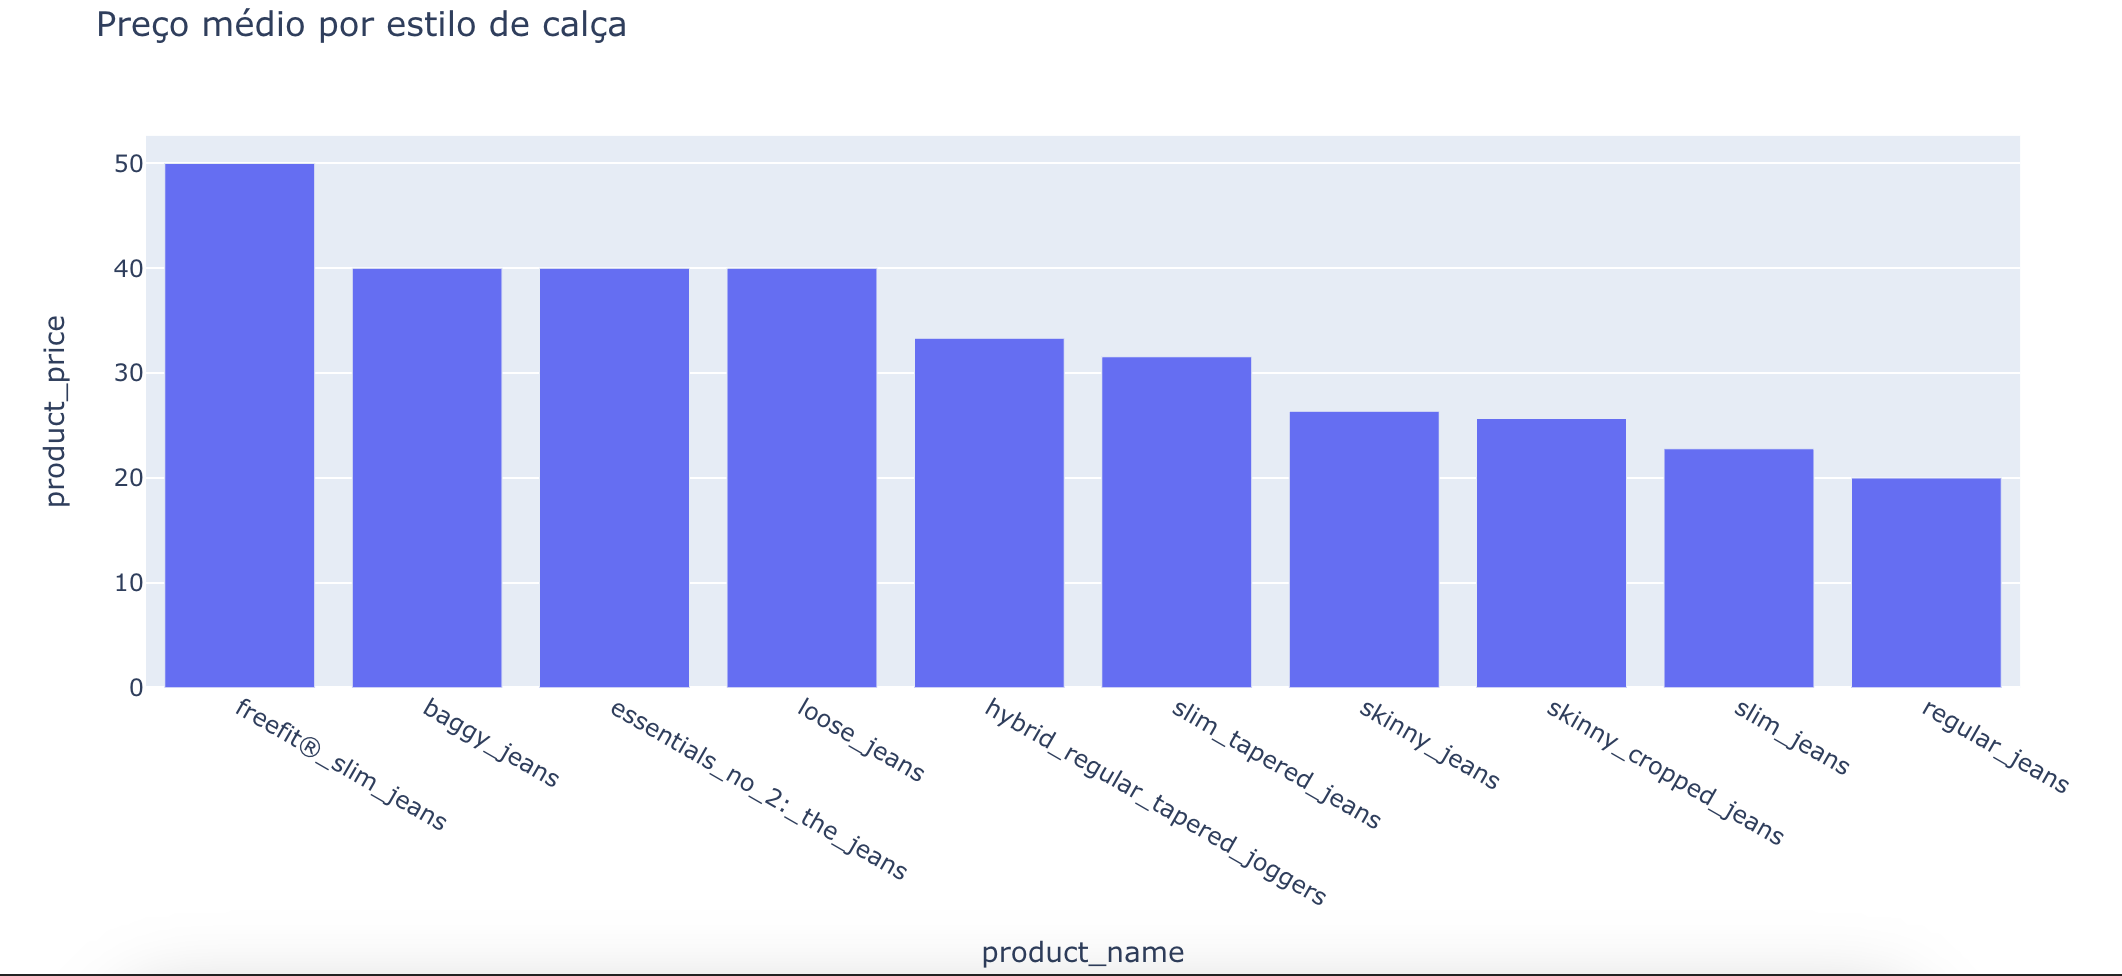

In [40]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph01.png'
Image(filename = PATH, width=1000, height=1000)

In [28]:
# Média de preço por cores de calças
df_mean_price_by_color = df01[['color_name','product_price']].groupby('color_name').mean().sort_values('product_price', ascending=False).reset_index()
df_mean_price_by_color

color_name  product_price
0        black/no_fade_black      49.990000
1            black/patterned      39.990000
2              black/trashed      39.990000
3                     purple      39.990000
4   light_denim_gray/trashed      39.990000
5                       gray      39.990000
6                 denim_gray      36.656667
7            dark_denim_blue      32.847143
8                      black      32.775714
9           light_denim_blue      31.104286
10                denim_blue      31.058966
11           dark_denim_gray      29.990000
12                light_gray      27.323333
13   dark_denim_blue/trashed      25.990000
14                     white      25.132857
15                 dark_gray      23.899091
16                light_blue      22.990000
17        denim_blue/trashed      21.990000
18           pale_denim_blue      21.990000
19  light_denim_blue/trashed      21.490000
20         dark_blue/trashed      20.990000
21      dark_blue/washed_out      19.990000
22                 dark_blue      19.865000
23          black_washed_out      17.990000
24              black/washed      17.990000

In [29]:
# Preço médio por cores de calças
import plotly.express as px
px.bar(df_mean_price_by_color, x="color_name", y="product_price", title = "Preço médio por cores")

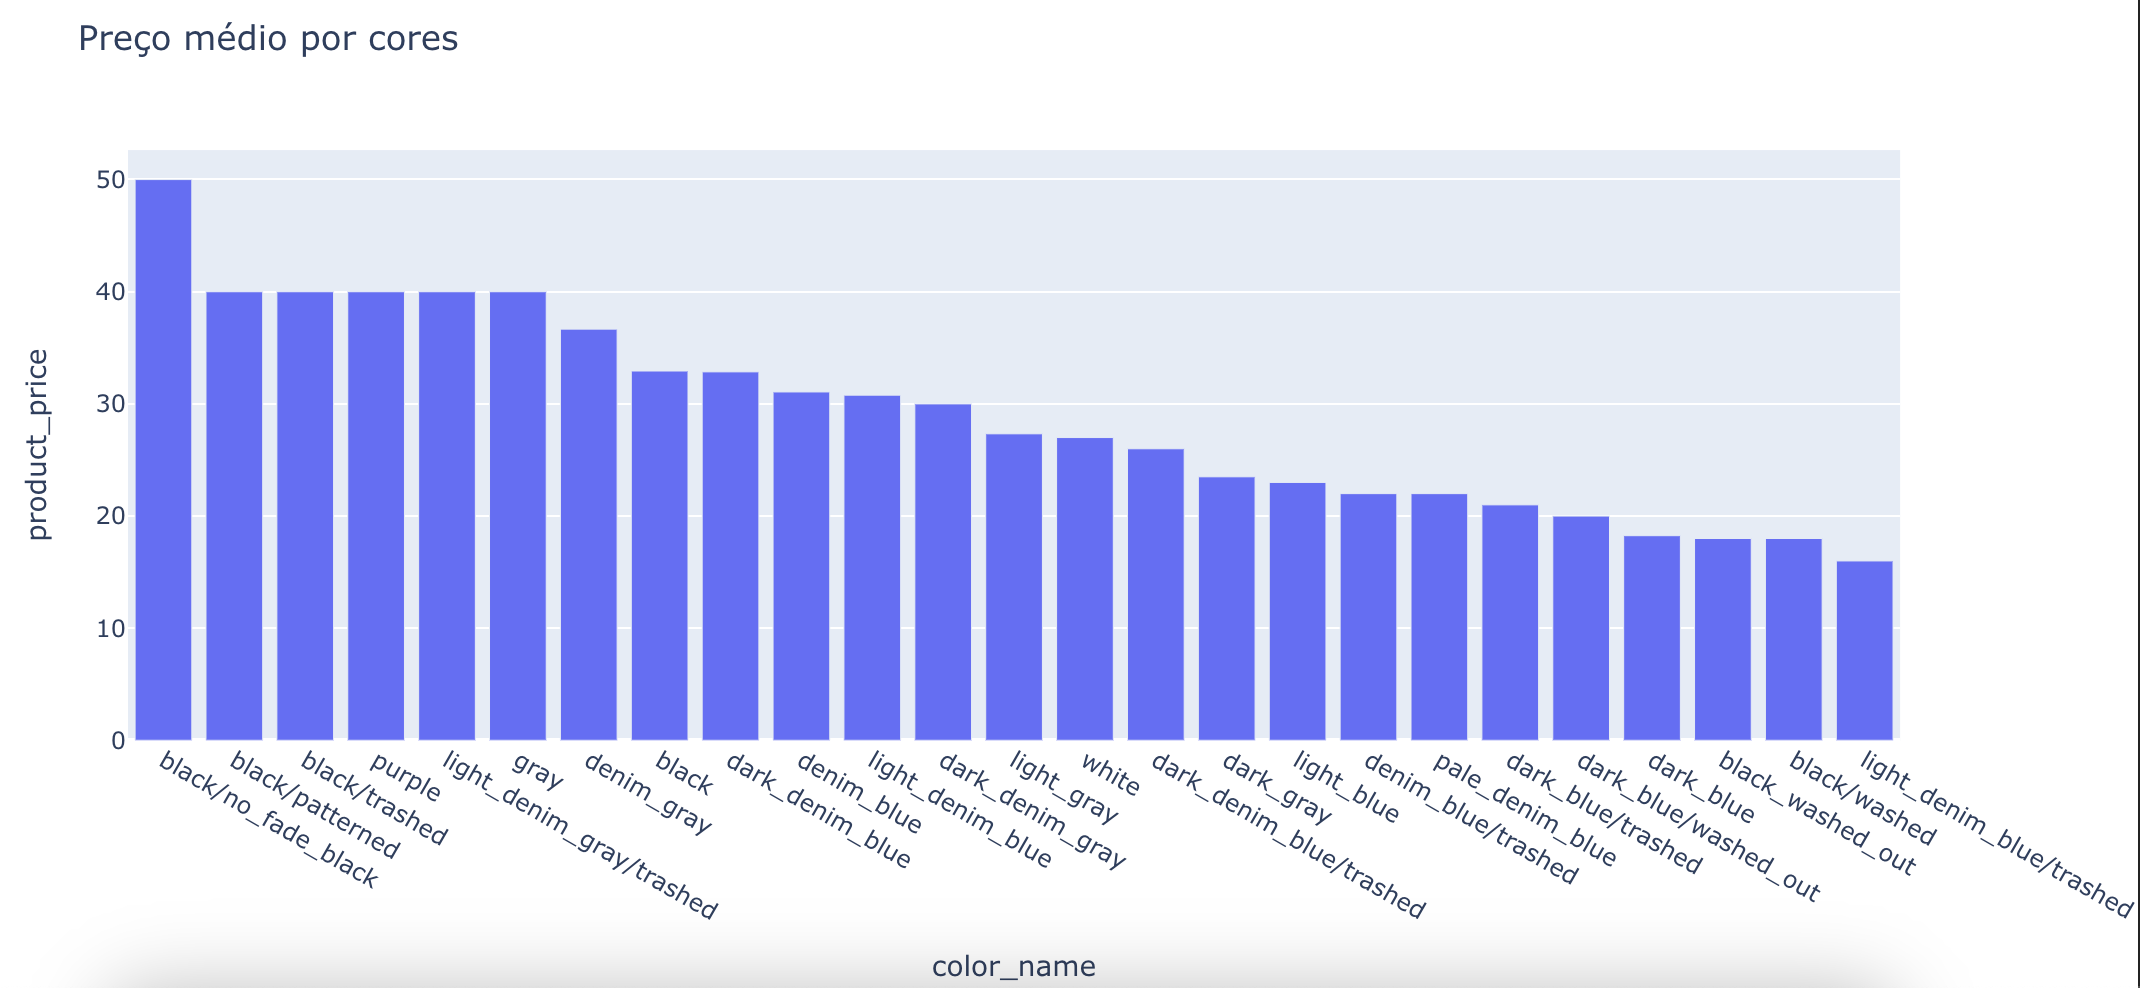

In [41]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph02.png'
Image(filename = PATH, width=1000, height=1000)

In [38]:
# Quantidade de tipos de calças por cores
fig = px.histogram(df01.drop_duplicates(subset = 'product_id'), x="color_name", color="product_name", title = "Quantidade de tipos de calças por cores").update_xaxes(categoryorder='total descending')
fig.show()

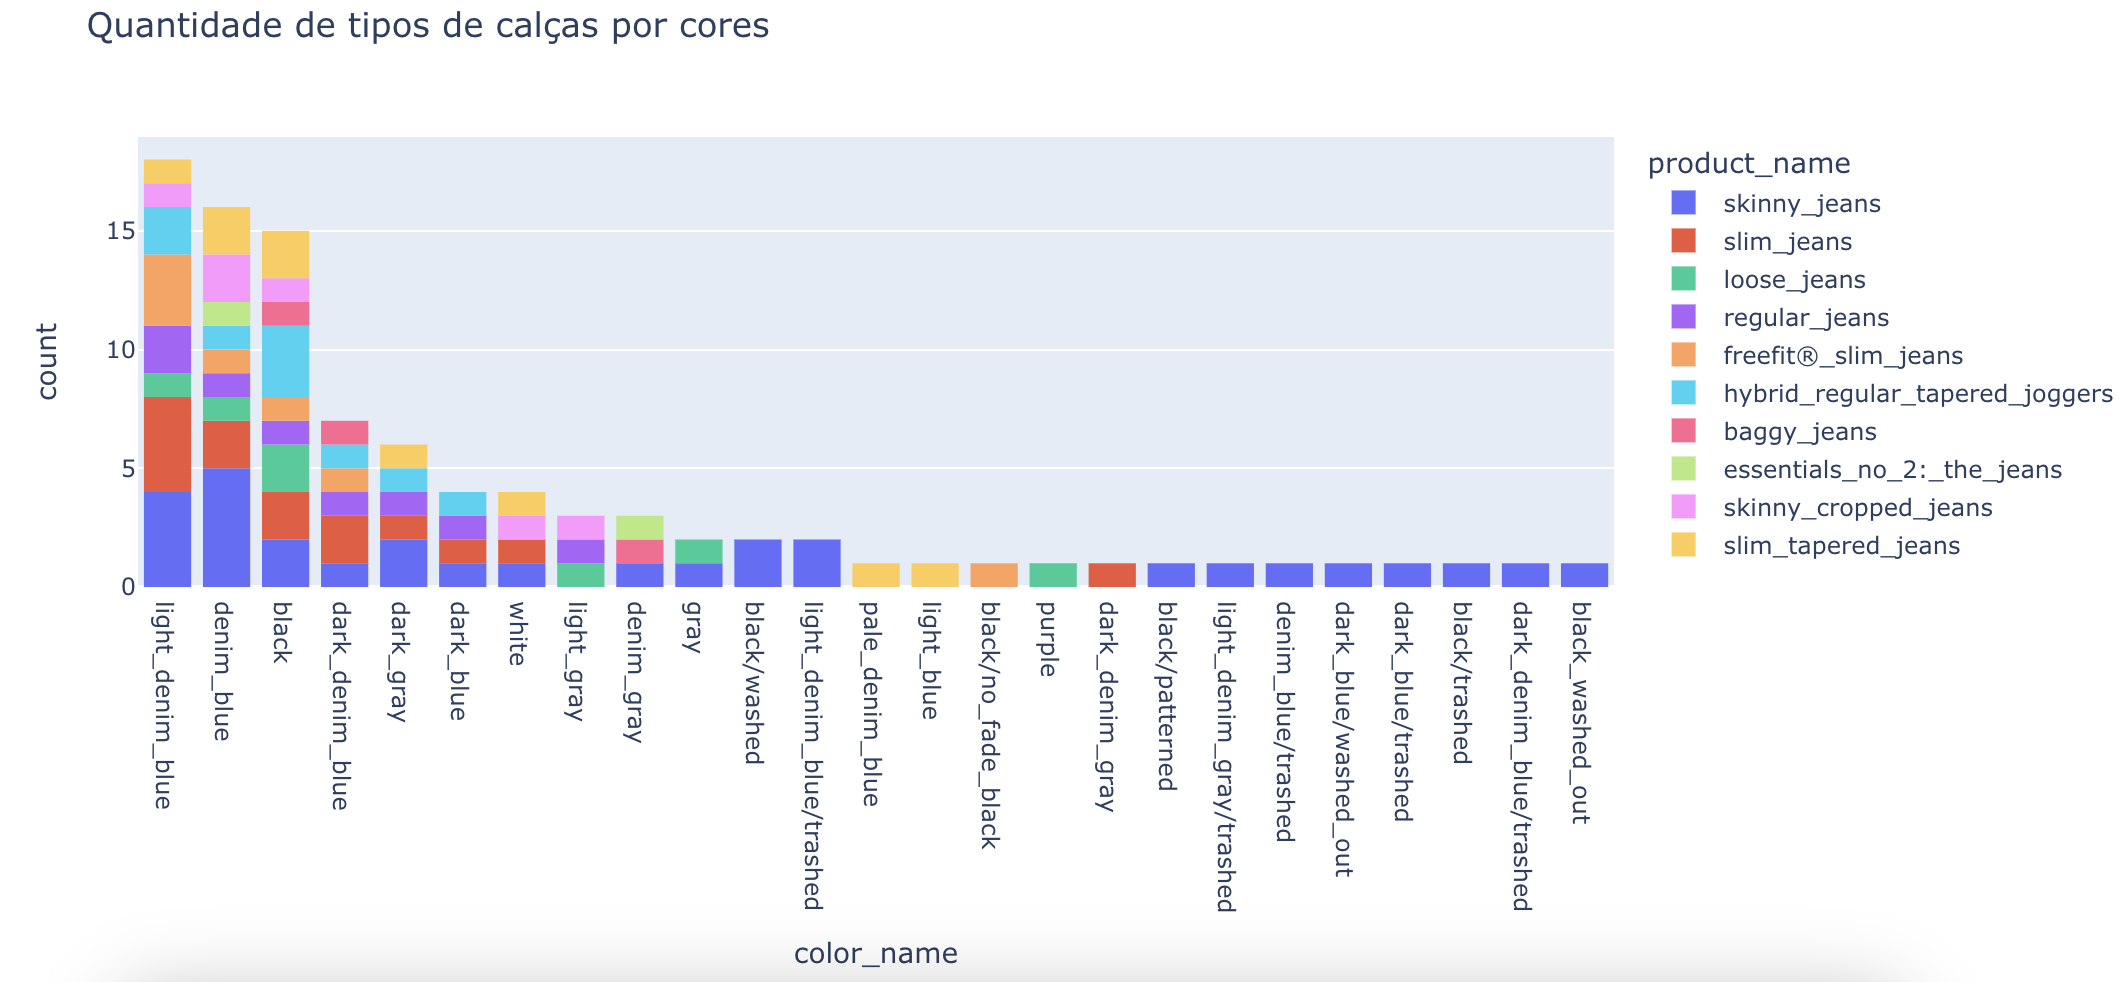

In [42]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph03.png'
Image(filename = PATH, width=1000, height=1000)

A sugestão na escolha das cores para as calças, é escolher uma cor que aparece em todos os modelos de calças. Assim podemos economizar com o preço do tecido aproveitando eles para todos os tipos de calças.

Como podemos ver no gráfico acima, as cores light_denim_blue, black, denim_blue e dark_denim_blue aparecem na maioria dos modelos de calça.

In [31]:
# Selecionando somente as cores destacadas na sugestão acima para ver quantos modelos de jeans que utilizam essas 4 cores.
df_jeans = df01[df01['color_name'].isin(['black', 'light_denim_blue', 'denim_blue', 'dark_denim_blue'])]

In [39]:
# Gráfico para identificar quais modelos de jeans utilizam as 4 cores escolhidas.
fig = px.histogram(df_jeans.drop_duplicates(subset = 'product_id'), x="product_name", color="color_name", title = "Modelos de jeans que utilizam as quatro cores escolhidas").update_xaxes(categoryorder='total descending')
fig.show()

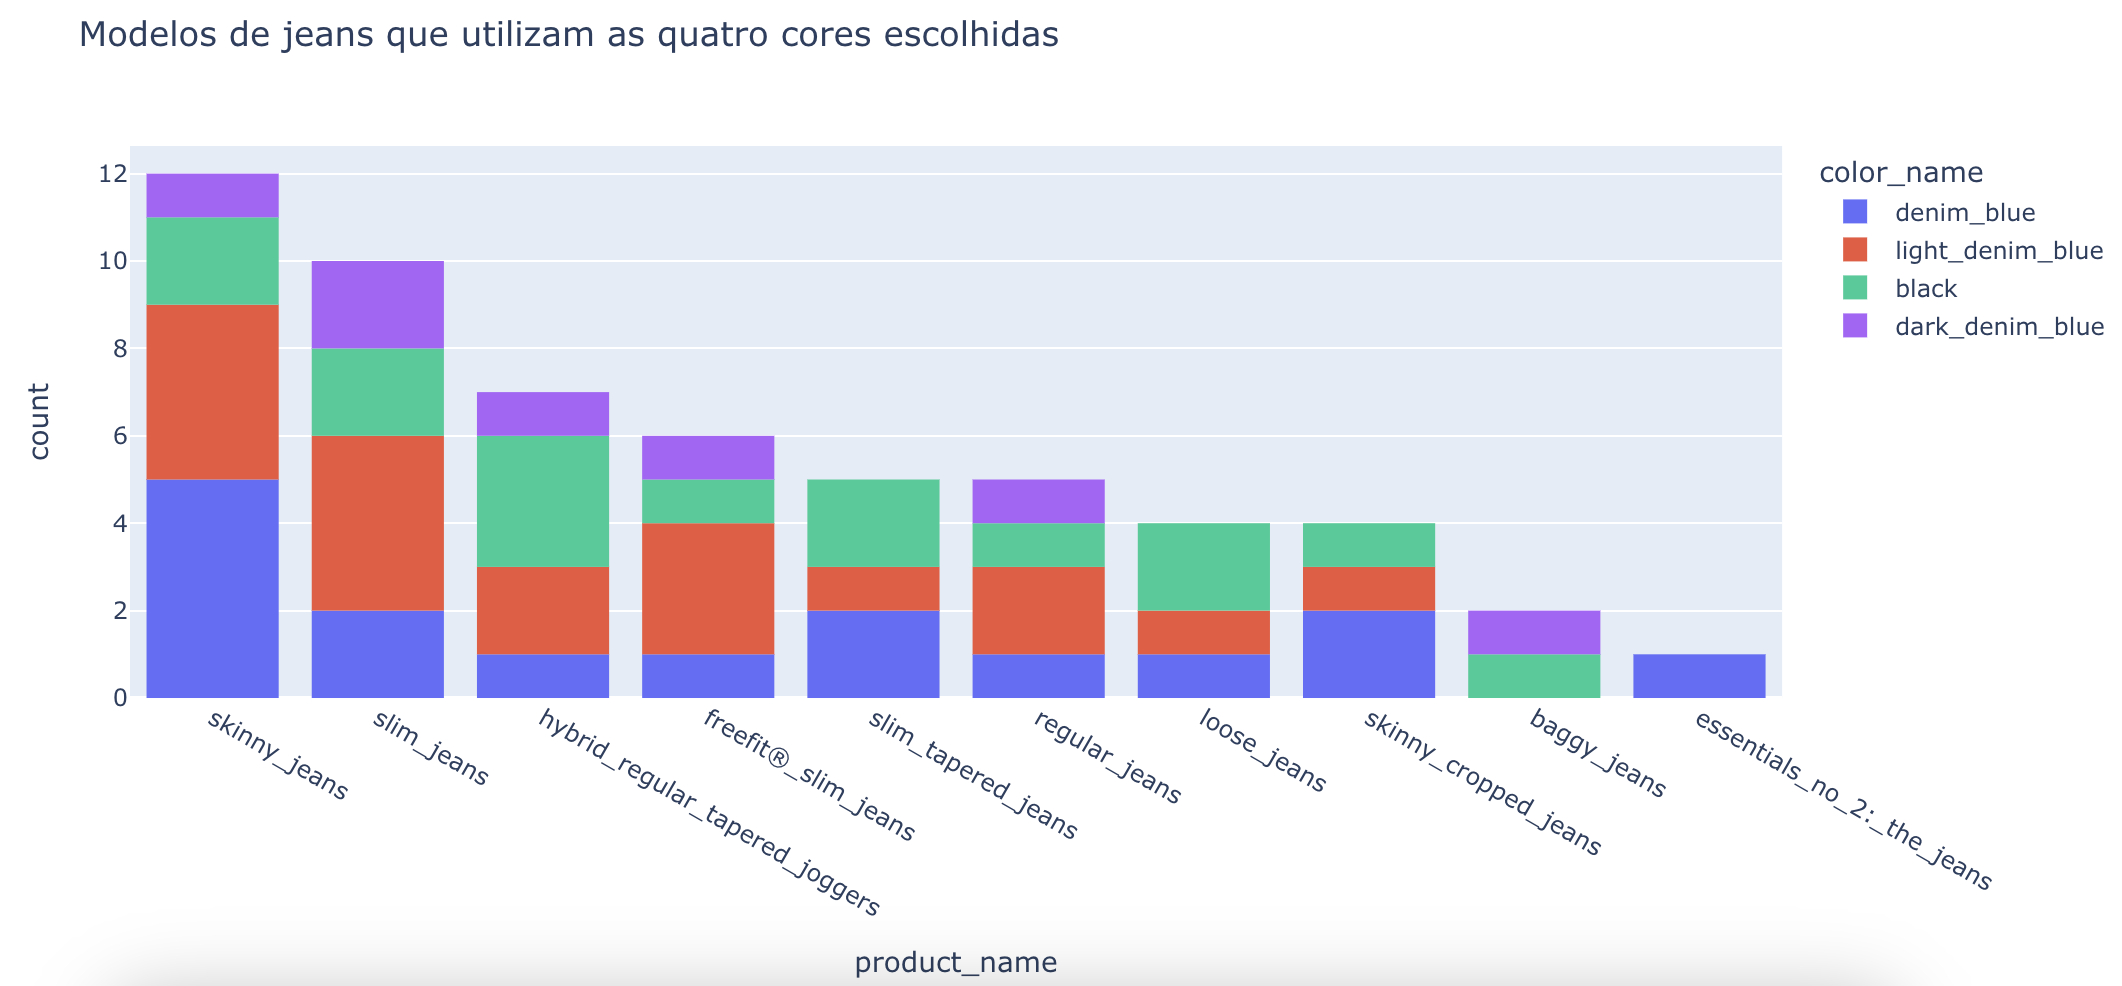

In [43]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph04.png'
Image(filename = PATH, width=1000, height=1000)

A sugestão para a escolha dos modelos é utilizar modelos que tenham as 4 cores que escolhemos na sugestão anterior. 

Então nesse caso vamos escolher apenas 4 modelos de jeans para iniciar o negócio.

Modelos escolhidos:
- relaxed_jeans
- skinny_jeans
- slim_jeans
- regular_jeans

### 2.2. Quais as matérias-prima necessárias para confeccionar as calças?

In [33]:
# Selecionando somente os modelos e cores de jeans escolhidos, dropandos product_id duplicados para ver a matéria prima de cada um.
df_feedstock = df01[df01['product_name'].isin(['relaxed_jeans', 'skinny_jeans', 'slim_jeans', 'regular_jeans'])
                   & df01['color_name'].isin(['light_denim_blue', 'black', 'denim_blue', 'dark_denim_blue'])].drop_duplicates(subset = 'product_id').reset_index()
df_feedstock

index  product_id style_id color_id   product_name        color_name  \
0       2  0690449002  0690449      002   skinny_jeans        denim_blue   
1       4  0690449007  0690449      007   skinny_jeans  light_denim_blue   
2      13  0690449036  0690449      036   skinny_jeans             black   
3      17  0690449056  0690449      056   skinny_jeans  light_denim_blue   
4      18  0690449059  0690449      059   skinny_jeans        denim_blue   
5      19  0690449062  0690449      062   skinny_jeans  light_denim_blue   
6      21  0690449067  0690449      067   skinny_jeans        denim_blue   
7      22  1024256001  1024256      001     slim_jeans             black   
8      23  1024256002  1024256      002     slim_jeans  light_denim_blue   
9      24  1024256003  1024256      003     slim_jeans  light_denim_blue   
10     25  1024256004  1024256      004     slim_jeans        denim_blue   
11     27  1024256006  1024256      006     slim_jeans   dark_denim_blue   
12     30  0985159001  0985159      001   skinny_jeans             black   
13     31  0985159002  0985159      002   skinny_jeans        denim_blue   
14     33  0985159004  0985159      004   skinny_jeans  light_denim_blue   
15     35  0985159006  0985159      006   skinny_jeans   dark_denim_blue   
16     36  0985159007  0985159      007   skinny_jeans        denim_blue   
17     44  1008549006  1008549      006  regular_jeans             black   
18     45  1008549001  1008549      001  regular_jeans  light_denim_blue   
19     46  1008549002  1008549      002  regular_jeans        denim_blue   
20     49  1008549005  1008549      005  regular_jeans   dark_denim_blue   
21     51  1008549008  1008549      008  regular_jeans  light_denim_blue   
22     52  1024711006  1024711      006     slim_jeans   dark_denim_blue   
23     53  1024711001  1024711      001     slim_jeans             black   
24     54  1024711002  1024711      002     slim_jeans  light_denim_blue   
25     55  1024711004  1024711      004     slim_jeans  light_denim_blue   
26     57  1024711010  1024711      010     slim_jeans        denim_blue   

            fit  product_price  cotton  polyester  spandex     scrapy_datetime  
0    skinny_fit          14.99    0.98       0.00     0.02 2022-11-28 21:08:16  
1    skinny_fit          14.99    1.00       0.00     0.02 2022-11-28 21:08:16  
2    skinny_fit          39.99    0.98       0.00     0.02 2022-11-28 21:08:16  
3    skinny_fit          39.99    0.98       0.65     0.02 2022-11-28 21:08:16  
4    skinny_fit          39.99    0.98       0.65     0.02 2022-11-28 21:08:16  
5    skinny_fit          39.99    0.98       0.65     0.02 2022-11-28 21:08:16  
6    skinny_fit          39.99    0.98       0.65     0.02 2022-11-28 21:08:16  
7      slim_fit          19.99    0.99       0.65     0.01 2022-11-28 21:08:16  
8      slim_fit          19.99    0.99       0.65     0.01 2022-11-28 21:08:16  
9      slim_fit          19.99    0.99       0.65     0.01 2022-11-28 21:08:16  
10     slim_fit          19.99    0.99       0.65     0.01 2022-11-28 21:08:16  
11     slim_fit          19.99    1.00       0.00     0.01 2022-11-28 21:08:16  
12   skinny_fit          24.99    1.00       0.00     0.01 2022-11-28 21:08:16  
13   skinny_fit          15.99    1.00       0.00     0.01 2022-11-28 21:08:16  
14   skinny_fit          24.99    1.00       0.00     0.01 2022-11-28 21:08:16  
15   skinny_fit          24.99    0.99       0.65     0.01 2022-11-28 21:08:16  
16   skinny_fit          24.99    0.99       0.65     0.01 2022-11-28 21:08:16  
17  regular_fit          24.99    1.00       0.00     0.01 2022-11-28 21:08:16  
18  regular_fit          24.99    0.98       0.65     0.02 2022-11-28 21:08:16  
19  regular_fit          24.99    0.99       0.65     0.01 2022-11-28 21:08:16  
20  regular_fit          24.99    1.00       0.00     0.01 2022-11-28 21:08:16  
21  regular_fit          10.99    0.99       0.65     0.01 2022-11-28 21:08:16  
22     slim_

### 2.3. Qual o melhor preço de venda para as calças?

Fazendo uma pesquisa de preços no Google em fornecedores da China, chegamos aos seguintes preços para os tecidos:
- Cotton m2: 1.15 - 1.6 USD
- Polyester m2: 1.9 - 2.01 USD
- Spandex m2: 1.95 - 2.15 USD

Pesquisando o salário médio de uma costureira nos Estados Unidos, chegamos no seguinte resultado:
- Salário base médio 16,70 USD por hora.

#### 2.3.1. Qual o melhor preço para bater o concorrente, incluindo preço do material e mão de obra de costura.

Estratégia 

- Calculo preço dos materiais:
    - Pegar a porcentagem de material de cada peça e se for maior que 0.50, multiplicar pelo preço máximo por metro quadrado do material vezes dois, considerando que vamos utilizar dois metros quadrados para montar a peça.
    - Se for menor que 0.50, multiplicar pelo preço máximo por metro quadrado do material, considerando que vamos utilizar apenas um metro quadrado para montar a peça.
   
- Calculo preço mão de obra
    - Pegar o salário base médio de 16,70 USD por hora e acrescentar em cada calça, considerando que uma costureira faz uma calça por hora.

In [34]:
# Preço cotton
def price_cotton(x):
    if (x['cotton'] > 0.50):
        return x['cotton'] * (1.6 * 2)
    else:
        return x['cotton'] * (1.6)
    
# Preço polyester
def price_polyester(x):
    if (x['polyester'] > 0.50):
        return x['polyester'] * (2.1 * 2)
    else:
        return x['polyester'] * (2.1)
    
# Preço spandex
def price_spandex(x):
    if (x['spandex'] > 0.50):
        return x['spandex'] * (2.15 * 2)
    else:
        return x['spandex'] * (2.15)

In [35]:
# Adicionando os preços de cada material
df_sales = df_feedstock.copy()

df_sales['price_cotton'] = df_sales.apply(price_cotton, axis = 1)

df_sales['price_polyester'] = df_sales.apply(price_polyester, axis = 1)

df_sales['price_spandex'] = df_sales.apply(price_spandex, axis = 1)

# Criando coluna de preço mao de obra por calça
df_sales['price_costureira'] = 16.70

# Criando coluna de preço total
df_sales['total_price'] = round(df_sales['price_costureira'] + df_sales['price_spandex'] + df_sales['price_polyester'] + df_sales['price_cotton'])

df_sales

index  product_id style_id color_id   product_name        color_name  \
0       2  0690449002  0690449      002   skinny_jeans        denim_blue   
1       4  0690449007  0690449      007   skinny_jeans  light_denim_blue   
2      13  0690449036  0690449      036   skinny_jeans             black   
3      17  0690449056  0690449      056   skinny_jeans  light_denim_blue   
4      18  0690449059  0690449      059   skinny_jeans        denim_blue   
5      19  0690449062  0690449      062   skinny_jeans  light_denim_blue   
6      21  0690449067  0690449      067   skinny_jeans        denim_blue   
7      22  1024256001  1024256      001     slim_jeans             black   
8      23  1024256002  1024256      002     slim_jeans  light_denim_blue   
9      24  1024256003  1024256      003     slim_jeans  light_denim_blue   
10     25  1024256004  1024256      004     slim_jeans        denim_blue   
11     27  1024256006  1024256      006     slim_jeans   dark_denim_blue   
12     30  0985159001  0985159      001   skinny_jeans             black   
13     31  0985159002  0985159      002   skinny_jeans        denim_blue   
14     33  0985159004  0985159      004   skinny_jeans  light_denim_blue   
15     35  0985159006  0985159      006   skinny_jeans   dark_denim_blue   
16     36  0985159007  0985159      007   skinny_jeans        denim_blue   
17     44  1008549006  1008549      006  regular_jeans             black   
18     45  1008549001  1008549      001  regular_jeans  light_denim_blue   
19     46  1008549002  1008549      002  regular_jeans        denim_blue   
20     49  1008549005  1008549      005  regular_jeans   dark_denim_blue   
21     51  1008549008  1008549      008  regular_jeans  light_denim_blue   
22     52  1024711006  1024711      006     slim_jeans   dark_denim_blue   
23     53  1024711001  1024711      001     slim_jeans             black   
24     54  1024711002  1024711      002     slim_jeans  light_denim_blue   
25     55  1024711004  1024711      004     slim_jeans  light_denim_blue   
26     57  1024711010  1024711      010     slim_jeans        denim_blue   

            fit  product_price  cotton  polyester  spandex  \
0    skinny_fit          14.99    0.98       0.00     0.02   
1    skinny_fit          14.99    1.00       0.00     0.02   
2    skinny_fit          39.99    0.98       0.00     0.02   
3    skinny_fit          39.99    0.98       0.65     0.02   
4    skinny_fit          39.99    0.98       0.65     0.02   
5    skinny_fit          39.99    0.98       0.65     0.02   
6    skinny_fit          39.99    0.98       0.65     0.02   
7      slim_fit          19.99    0.99       0.65     0.01   
8      slim_fit          19.99    0.99       0.65     0.01   
9      slim_fit          19.99    0.99       0.65     0.01   
10     slim_fit          19.99    0.99       0.65     0.01   
11     slim_fit          19.99    1.00       0.00     0.01   
12   skinny_fit          24.99    1.00       0.00     0.01   
13   skinny_fit          15.99    1.00       0.00     0.01   
14   skinny_fit          24.99    1.00       0.00     0.01   
15   skinny_fit          24.99    0.99       0.65     0.01   
16   skinny_fit          24.99    0.99       0.65     0.01   
17  regular_fit          24.99    1.00       0.00     0.01   
18  regular_fit          24.99    0.98       0.65     0.02   
19  regular_fit          24.99    0.99       0.65     0.01   
20  regular_fit          24.99    1.00       0.00     0.01   
21  regular_fit          10.99    0.99       0.65     0.01   
22     slim_fit          29.99    1.00       0.00     0.02   
23     slim_fit          29.99    1.00       0.00     0.02   
24     slim_fit          29.99    1.00       0.00     0.01   
25     slim_fit           8.99    1.00       0.00     0.01   
26     slim_fit          29.99    0.99       0.80     0.01   

       scrapy_datetime  price_cotton  price_polyester  price_spandex  \
0  2022-11-28 21:08:16         3.136             0.00         0.04

#### 2.3.2. Calcular o lucro de cada peça, tirando o preço do material e mão de obra de costura

Calculo de lucro:
- Ver quantas peças podemos ter lucro, subtraindo o preço do concorrente do total price.
- Vamos fabricar e vender as peças onde podemos obter o mesmo preço do concorrente com a mão de obra e lucro.
- Desconsideraremos peças que apresentarem valores negativos.

In [36]:
# Calculo de lucro
df_sales['lucro'] = df_sales['product_price'] - df_sales['total_price']

In [37]:
# Criar coluna de preço final com o preço total de cada calça + lucro
df_sales['final_price'] = df_sales['total_price'] + df_sales['lucro']
df_sales[(df_sales['lucro'] > 0)]

index  product_id style_id color_id   product_name        color_name  \
2      13  0690449036  0690449      036   skinny_jeans             black   
3      17  0690449056  0690449      056   skinny_jeans  light_denim_blue   
4      18  0690449059  0690449      059   skinny_jeans        denim_blue   
5      19  0690449062  0690449      062   skinny_jeans  light_denim_blue   
6      21  0690449067  0690449      067   skinny_jeans        denim_blue   
12     30  0985159001  0985159      001   skinny_jeans             black   
14     33  0985159004  0985159      004   skinny_jeans  light_denim_blue   
15     35  0985159006  0985159      006   skinny_jeans   dark_denim_blue   
16     36  0985159007  0985159      007   skinny_jeans        denim_blue   
17     44  1008549006  1008549      006  regular_jeans             black   
18     45  1008549001  1008549      001  regular_jeans  light_denim_blue   
19     46  1008549002  1008549      002  regular_jeans        denim_blue   
20     49  1008549005  1008549      005  regular_jeans   dark_denim_blue   
22     52  1024711006  1024711      006     slim_jeans   dark_denim_blue   
23     53  1024711001  1024711      001     slim_jeans             black   
24     54  1024711002  1024711      002     slim_jeans  light_denim_blue   
26     57  1024711010  1024711      010     slim_jeans        denim_blue   

            fit  product_price  cotton  polyester  spandex  \
2    skinny_fit          39.99    0.98       0.00     0.02   
3    skinny_fit          39.99    0.98       0.65     0.02   
4    skinny_fit          39.99    0.98       0.65     0.02   
5    skinny_fit          39.99    0.98       0.65     0.02   
6    skinny_fit          39.99    0.98       0.65     0.02   
12   skinny_fit          24.99    1.00       0.00     0.01   
14   skinny_fit          24.99    1.00       0.00     0.01   
15   skinny_fit          24.99    0.99       0.65     0.01   
16   skinny_fit          24.99    0.99       0.65     0.01   
17  regular_fit          24.99    1.00       0.00     0.01   
18  regular_fit          24.99    0.98       0.65     0.02   
19  regular_fit          24.99    0.99       0.65     0.01   
20  regular_fit          24.99    1.00       0.00     0.01   
22     slim_fit          29.99    1.00       0.00     0.02   
23     slim_fit          29.99    1.00       0.00     0.02   
24     slim_fit          29.99    1.00       0.00     0.01   
26     slim_fit          29.99    0.99       0.80     0.01   

       scrapy_datetime  price_cotton  price_polyester  price_spandex  \
2  2022-11-28 21:08:16         3.136             0.00         0.0430   
3  2022-11-28 21:08:16         3.136             2.73         0.0430   
4  2022-11-28 21:08:16         3.136             2.73         0.0430   
5  2022-11-28 21:08:16         3.136             2.73         0.0430   
6  2022-11-28 21:08:16         3.136             2.73         0.0430   
12 2022-11-28 21:08:16         3.200             0.00         0.0215   
14 2022-11-28 21:08:16         3.200             0.00         0.0215   
15 2022-11-28 21:08:16         3.168             2.73         0.0215   
16 2022-11-28 21:08:16         3.168             2.73         0.0215   
17 2022-11-28 21:08:16         3.200             0.00         0.0215   
18 2022-11-28 21:08:16         3.136             2.73         0.0430   
19 2022-11-28 21:08:16         3.168             2.73         0.0215   
20 2022-11-28 21:08:16         3.200             0.00         0.0215   
22 2022-11-28 21:08:16         3.200             0.00         0.0430   
23 2022-11-28 21:08:16         3.200             0.00         0.0430   
24 2022-11-28 21:08:16         3.200             0.00         0.0215   
26 2022-11-28 21:08:16         3.168             3.36         0.0215   

    price_costureira  total_price  lucro  final_price  
2               16.7         20.0  19.99        39.99  
3               16.7         23.0  16.99        39.99  
4               16.7         23.0  16.99        39.99